In [34]:
import pandas as pd
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Load libraries
import datetime as dt
from datetime import datetime
import time 
import calendar
start_time = datetime.now()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.stats as sps
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import StackingClassifier

import keras
from imblearn.over_sampling import SMOTE

import math
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer

In [35]:
X=pd.read_csv('train_data_13.csv')
y=pd.read_csv('y_train_13.csv')
X_oot=pd.read_csv('oot_data_13.csv')
y_oot=pd.read_csv('y_oot_13.csv')

## Cross Validation

In [ ]:
def random_split(model, X, y, X_oot, y_oot, random_state, test_size):
    scores_test = []
    scores_train = []
    scores_oot = []
    for rs in random_state:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=rs,stratify=y)
      
        model_obj = model.fit(X_train, y_train.values.ravel())
            # Score the model on the (non-upsampled) validation dat
        train_fdr = fdr(y_train.values.ravel(), model_obj.predict_proba(X_train)[:,1])
        test_fdr = fdr(y_test.values.ravel(), model_obj.predict_proba(X_test)[:,1])
        oot_fdr = fdr(y_oot.values.ravel(), model_obj.predict_proba(X_oot)[:,1])
        scores_train.append(train_fdr)
        scores_test.append(test_fdr)
        scores_oot.append(oot_fdr)
    print(f'Train FDR: {np.mean(scores_train)}')
    print(f'Test FDR: {np.mean(scores_test)}')
    print(f'OOT FDR: {np.mean(scores_oot)}')
    
random_state=[0,1,21,34,77,12,898,15,51,67]
random_split(rf, X,y, X_oot, y_oot, random_state, 0.2)

## Auto cross validation method

In [3]:
def score_model_original(model, X, y, X_oot, y_oot, cv=None):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    if cv is None:
        #cv = KFold(n_splits=5)
        cv = StratifiedKFold(n_splits = 3, random_state = 1, shuffle = True)
        
    #from imblearn.over_sampling import SMOTE
    #smoter = SMOTE(sampling_strategy='minority')
    
    scores_test = []
    scores_train = []
    scores_oot = []

    for train_fold_index, val_fold_index in cv.split(X, y):
        #print(train_fold_index,val_fold_index)
        # Get the training data
        X_train_fold, y_train_fold = X.iloc[train_fold_index,:], y.iloc[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X.iloc[val_fold_index,:], y.iloc[val_fold_index]
        # Upsample only the data in the training section
        #X_train_fold_upsample, y_train_fold_upsample = smoter.fit_sample(X_train_fold, y_train_fold)
        # Fit the model on the upsampled training data
        model_obj = model.fit(X_train_fold, y_train_fold.values.ravel())
        # Score the model on the (non-upsampled) validation dat
        train_fdr = fdr(y_train_fold.values.ravel(), model_obj.predict_proba(X_train_fold)[:,1])
        test_fdr = fdr(y_val_fold.values.ravel(), model_obj.predict_proba(X_val_fold)[:,1])
        oot_fdr = fdr(y_oot.values.ravel(), model_obj.predict_proba(X_oot)[:,1])
        scores_train.append(train_fdr)
        scores_test.append(test_fdr)
        scores_oot.append(oot_fdr)
        
    
    print(f'Train FDR: {np.mean(scores_train)}')
    print(f'Test FDR: {np.mean(scores_test)}')
    print(f'OOT FDR: {np.mean(scores_oot)}')
    return scores_oot

# Example of the model in action
#score_model(RandomForestClassifier, example_params)

## Models

### 1. Logistic

In [ ]:
#!pip install Scikit-Optimize

# Using a random forest to optimize
from skopt import forest_minimize

def tune_rf(params):
# Implementation learned on a lesson of Mario Filho (Kagle Grandmaster) for parametes optmization.
# Link to the video: https://www.youtube.com/watch?v=WhnkeasZNHI

    """Function to be passed as scikit-optimize minimizer/maximizer input

    Parameters:
    Tuples with information about the range that the optimizer should use for that parameter, 
    as well as the behaviour that it should follow in that range.

    Returns:
    float: the metric that should be minimized. If the objective is maximization, then the negative 
    of the desired metric must be returned. In this case, the negative AUC average generated by CV is returned.
    """


    #Hyperparameters to be optimized
    print(params)
    min_samples_split = params[0] 
    n_estimators = params[1] 
    max_depth = params[2]
    min_samples_leaf = params[3] # min node size
    #min_weight_fraction_leaf = params[4]
   # max_features = params[4]
    #max_leaf_nodes=params[4]

    #Model to be optimized
    
    
    rf = RandomForestClassifier(min_samples_split = min_samples_split, 
                            n_estimators = n_estimators, 
                            max_depth = max_depth, 
                            min_samples_leaf = min_samples_leaf, 
                            #min_weight_fraction_leaf = min_weight_fraction_leaf, 
                            #max_features = max_features, 
                               n_jobs=-1,
                                #verbose = 2,
                               oob_score = True,
                                bootstrap= True,
                               class_weight = 'balanced') # bootstrap
                               #max_leaf_nodes=max_leaf_nodes)
#                             objective= 'binary:logistic', 
#                             eval_metric = 'error',
#                             seed = 42)


    #Cross-Validation in order to avoid overfitting
    #kfolds = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True)
    #score = make_scorer(fdr, needs_proba = True)
    #cv_fdr = cross_val_score(rf, X_sm, y_sm.values.ravel(), cv = 2, scoring = score)
    cv_fdr = score_model_original(rf,X_23, y_23, X_oot_23, y_oot_23)
    print(np.mean(cv_fdr))
    # as the function is minimization (forest_minimize), we need to use the negative of the desired metric
    return -np.mean(cv_fdr)

# Creating a sample space in which the initial randomic search should be performed
space = [(5, 100), # min_samples_split
          (400, 700), # n_estimators
          (50, 200), # max_depth 
          (10,20)] # min_samples_leaf 
          #(0,0.5) # min_weight_fraction_leaf
          #('auto','sqrt','log2'), # max_features 
          # (15,30)]#max_leaf_nodes
 # Minimization using a random forest with 20 random samples and 30 iterations for Bayesian optimization.
result = forest_minimize(tune_rf, space, random_state = 0, n_random_starts = 2, n_calls  = 30, verbose = 1)

### 2. SVC

In [ ]:
#!pip install Scikit-Optimize

# Using a random forest to optimize
from skopt import forest_minimize
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def tune_rf(params):
# Implementation learned on a lesson of Mario Filho (Kagle Grandmaster) for parametes optmization.
# Link to the video: https://www.youtube.com/watch?v=WhnkeasZNHI

    """Function to be passed as scikit-optimize minimizer/maximizer input

    Parameters:
    Tuples with information about the range that the optimizer should use for that parameter, 
    as well as the behaviour that it should follow in that range.

    Returns:
    float: the metric that should be minimized. If the objective is maximization, then the negative 
    of the desired metric must be returned. In this case, the negative AUC average generated by CV is returned.
    """


    #Hyperparameters to be optimized
    print(params)
    gamma = params[0] 
    degree = params[1] 
    random_state = params[2]
    kernel = params[3]

    #Model to be optimized
    
    rf = make_pipeline(StandardScaler(), SVC(gamma=gamma,
                                             degree = degree, 
                            random_state = random_state, 
                            kernel = kernel,
                            probability = True))


    #Cross-Validation in order to avoid overfitting
    #kfolds = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True)
    #score = make_scorer(fdr, needs_proba = True)
    #cv_fdr = cross_val_score(rf, X_sm, y_sm.values.ravel(), cv = 2, scoring = score)
    cv_fdr = score_model_original(rf,X,y,X_oot,y_oot)
    print(np.mean(cv_fdr))
    # as the function is minimization (forest_minimize), we need to use the negative of the desired metric
    return -np.mean(cv_fdr)

# Creating a sample space in which the initial randomic search should be performed
space = [('scale', 'auto'), # min_samples_split
          (2, 4), # n_estimators
          (0, 100), # max_depth 
          ('linear','poly', 'rbf', 'sigmoid', 'precomputed')]#max_leaf_nodes
          

# Minimization using a random forest with 20 random samples and 30 iterations for Bayesian optimization.
result = forest_minimize(tune_rf, space, random_state = 42, n_random_starts = 20, n_calls  = 30, verbose = 1)

### 3. XGBoosted

In [ ]:
#!pip install Scikit-Optimize

# Using a random forest to optimize
from skopt import forest_minimize

def tune_xgbc(params):
# Implementation learned on a lesson of Mario Filho (Kagle Grandmaster) for parametes optmization.
# Link to the video: https://www.youtube.com/watch?v=WhnkeasZNHI

    """Function to be passed as scikit-optimize minimizer/maximizer input

    Parameters:
    Tuples with information about the range that the optimizer should use for that parameter, 
    as well as the behaviour that it should follow in that range.

    Returns:
    float: the metric that should be minimized. If the objective is maximization, then the negative 
    of the desired metric must be returned. In this case, the negative AUC average generated by CV is returned.
    """


    #Hyperparameters to be optimized
    print(params)
    learning_rate = params[0] 
    n_estimators = params[1] 
    max_depth = params[2]
    min_child_weight = params[3]
    gamma = params[4]
    subsample = params[5]
    colsample_bytree = params[6]


    #Model to be optimized
    
    xgbs = XGBClassifier(learning_rate = learning_rate, 
                            n_estimators = n_estimators, 
                            max_depth = max_depth, 
                            min_child_weight = min_child_weight, 
                            gamma = gamma, 
                            subsample = subsample, 
                            colsample_bytree = colsample_bytree, 
                            objective= 'binary:logistic', 
                            eval_metric = 'error',
                            seed = 42)


    #Cross-Validation in order to avoid overfitting
    #kfolds = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True)
    #cv_accuracy = cross_val_score(xgbs, X_scale, y_sm.values.ravel(), cv = 2, scoring = score)
    
    cv_fdr = score_model_original(xgbs, X, y, X_oot, y_oot)
    print(np.mean(cv_fdr))
    # as the function is minimization (forest_minimize), we need to use the negative of the desired metric
    return -np.mean(cv_fdr)


# Creating a sample space in which the initial randomic search should be performed
space = [(0.01, 0.05, 'log-uniform'), # learning rate
          (500, 1500), # n_estimators
          (1, 5), # max_depth 
          (1, 5), # min_child_weight 
          (0, 2), # gamma 
          (0.5, 1), # subsample 
          (0.5, 1)] # colsample_bytree
          

# Minimization using a random forest with 20 random samples and 30 iterations for Bayesian optimization.
result = forest_minimize(tune_xgbc, space, random_state = 42, n_random_starts = 20, n_calls  = 30, verbose = 1)

### 4. Random Forest

In [ ]:
#!pip install Scikit-Optimize

# Using a random forest to optimize
from skopt import forest_minimize
from sklearn.linear_model import LogisticRegression

def tune_rf(params):
# Implementation learned on a lesson of Mario Filho (Kagle Grandmaster) for parametes optmization.
# Link to the video: https://www.youtube.com/watch?v=WhnkeasZNHI

    """Function to be passed as scikit-optimize minimizer/maximizer input

    Parameters:
    Tuples with information about the range that the optimizer should use for that parameter, 
    as well as the behaviour that it should follow in that range.

    Returns:
    float: the metric that should be minimized. If the objective is maximization, then the negative 
    of the desired metric must be returned. In this case, the negative AUC average generated by CV is returned.
    """


    #Hyperparameters to be optimized
    print(params)
    penalty = params[0] 
    solver = params[1] 
    random_state = params[2]
    multi_class = params[3]
    #min_weight_fraction_leaf = params[4]
    verbose = params[4]
    #max_leaf_nodes=params[5]

    #Model to be optimized
    
    lg = LogisticRegression(penalty = penalty, 
                            solver = solver, 
                            random_state = random_state, 
                            multi_class = multi_class, 
                            #min_weight_fraction_leaf = min_weight_fraction_leaf, 
                            verbose = verbose, 
                            n_jobs=-1,
                            class_weight = 'balanced')
                            #max_leaf_nodes=max_leaf_nodes)
#                             objective= 'binary:logistic', 
#                             eval_metric = 'error',
#                             seed = 42)


    #Cross-Validation in order to avoid overfitting
    #kfolds = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True)
    #score = make_scorer(fdr, needs_proba = True)
    #cv_fdr = cross_val_score(rf, X_sm, y_sm.values.ravel(), cv = 2, scoring = score)
    cv_fdr = score_model_original(lg,X,y,X_oot,y_oot)
    print(np.mean(cv_fdr))
    return -np.mean(cv_fdr)

# Creating a sample space in which the initial randomic search should be performed
space = [('l1','l2', 'none'), # min_samples_split
          ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'), # n_estimators
          (0,20), # max_depth 
          ('auto', 'ovr', 'multinomial'), # min_samples_leaf 
          #(0,0.5), # min_weight_fraction_leaf
          (0,5)]#max_leaf_nodes
          

# Minimization using a random forest with 20 random samples and 30 iterations for Bayesian optimization.
result = forest_minimize(tune_rf, space, random_state = 42, n_random_starts = 20, n_calls  = 30, verbose = 1)

## Final Model

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=2,stratify=y )

In [37]:
def fdr(true_y, prob_y):
    n_rows = int(round(len(true_y)) * 0.03)
    numBads = sum(true_y)
    df = pd.DataFrame()
    df['pred_prob'] = list(prob_y)
    df['label'] = list(true_y)
    df = df.sort_values('pred_prob', ascending = False)
    fdr = df.head(n_rows)['label'].sum() / numBads
    return fdr

In [45]:
rf = RandomForestClassifier(min_samples_split = 60, 
                            n_estimators = 50, #50
                            max_depth = 25, 
                            min_samples_leaf = 30, 
                               n_jobs=-1,
                               class_weight = 'balanced')
rf.fit(X_train, y_train.values.ravel())
proba_train_y=rf.predict_proba(X_train)[:,1]
print(('Train FDR at 3%: {:.10f}'.format(fdr(y_train.values,proba_train_y)[0])))
proba_test_y=rf.predict_proba(X_test)[:,1]
print(('Test FDR at 3%: {:.10f}'.format(fdr(y_test.values,proba_test_y)[0])))
proba_oot_y=rf.predict_proba(X_oot)[:,1]
print(('OOT FDR at 3%: {:.10f}'.format(fdr(y_oot.values,proba_oot_y)[0])))

Train FDR at 3%: 0.9985590778
Test FDR at 3%: 0.9540229885
OOT FDR at 3%: 0.6256983240


In [17]:
X_train["predict"] = proba_train_y
X_train["fraud_label"] = y_train
X_train = X_train.sort_values("predict", ascending = False)

X_test["predict"] = proba_test_y
X_test["fraud_label"] = y_test
X_test = X_test.sort_values("predict", ascending = False)

X_oot["predict"] = proba_oot_y
X_oot["fraud_label"] = y_oot
X_oot = X_oot.sort_values("predict", ascending = False)

/Users/haoyanzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/haoyanzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/haoyanzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [18]:
for data in [X_train, X_test, X_oot]:
    result = []
    for percent in range(1,21,1):
        n_row = int(round(len(data)*0.01*percent))
        bads = data[:n_row][data[:n_row]['fraud_label']==1]
        cul_bad = len(bads)
        result.append(cul_bad)
    print(result)

[614, 694, 694, 694, 694, 694, 694, 694, 694, 694, 694, 694, 694, 694, 694, 694, 694, 694, 694, 694]
[134, 163, 167, 167, 168, 168, 168, 168, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170]
[68, 100, 112, 122, 127, 133, 133, 138, 140, 140, 143, 145, 150, 152, 155, 155, 156, 157, 157, 157]


In [31]:
y_test.loc[y_test['Fraud']==1]

,Fraud
61376,1
27685,1
16721,1
63886,1
41821,1
...,...
79655,1
33332,1
58933,1
12043,1


In [32]:
y_oot.loc[y_oot['Fraud'] == 1]

,Fraud
362,1
1489,1
1563,1
2699,1
2709,1
...,...
11952,1
12199,1
12224,1
12383,1


## Fraud Saving

In [19]:
X=pd.read_csv('train_data_13.csv')
y=pd.read_csv('y_train_13.csv')
X_oot=pd.read_csv('oot_data_13.csv')
y_oot=pd.read_csv('y_oot_13.csv')

In [20]:
rf.fit(X, y.values.ravel())

RandomForestClassifier(class_weight='balanced', max_depth=180,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=110, n_jobs=-1)

In [21]:
df = pd.read_csv('clean_data.csv')
oot_data=df[(df.Date >= '2010-11-01')]
oot_data["predict"] = proba_oot_y
oot_data = oot_data.sort_values("predict", ascending = False)

/Users/haoyanzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
data=[]
for percent in range(0,51,1):
    n_row = int(round(len(oot_data)*0.01*percent))
    save=oot_data[:n_row][oot_data[:n_row]['Fraud']==1]['Fraud'].sum()*2000
    lose=len(oot_data[:n_row][oot_data[:n_row]['Fraud']==0]['Fraud'])*50
    overall_saving=save-lose
    data.append([percent,save,lose,overall_saving])
data=pd.DataFrame(data,columns=['Population','Fraud Saving','Lost Sales','Overall Saving'])

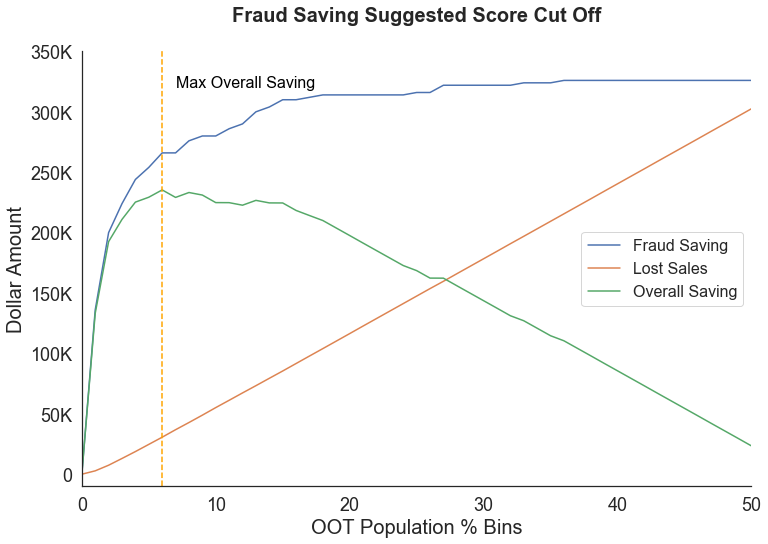

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
tickpositions_y=[0,50000,100000,150000,200000,250000,300000,350000]
ticklables_y=['0','50K','100K','150K','200K','250K','300K','350K']
sns.set(style='white')
plt.figure(figsize=(12, 8)) 
plt.plot(data['Population'], data['Fraud Saving'], label = "Fraud Saving")
plt.plot(data['Population'], data['Lost Sales'], label = "Lost Sales")
plt.plot(data['Population'], data['Overall Saving'], label = "Overall Saving")
plt.ylim(-10000,350000)
plt.xlim(0,50)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc='center right',fontsize = 16)
plt.xlabel('OOT Population % Bins',fontsize = 20)
plt.ylabel('Dollar Amount',fontsize = 20)
plt.title('Fraud Saving Suggested Score Cut Off', fontsize = 20, pad=30,fontweight="bold")
plt.yticks(tickpositions_y,ticklables_y)
plt.axvline(x=6,color='orange',linestyle='--')
plt.annotate('Max Overall Saving',(7,320000),color='black',fontsize=16)
plt.show()